### Ch.00 : Airline Table

In [1]:
import pandas, warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
air = "airline.csv"

airline = pandas.read_table(air, sep=",", parse_dates=["Month"])

airline.columns = ["Month", "Monthly Passengers"]

airline = airline.set_index("Month").sort_index()

airline.iloc[:5]

,Monthly Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
airline.tail()

,Monthly Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [4]:
airline.index.min().date()

datetime.date(1949, 1, 1)

In [5]:
airline.index.max().date()

datetime.date(1960, 12, 1)

In [6]:
null = airline.isnull().sum()

null.sum()

0

In [7]:
total_airline = airline.shape[0]

total_airline

144

🚀 Ch.00 Result

Our Airline Table is From January 1949 to December 1960

Our Airline Table is Clear of Missing Value

### Ch.01 : Airline Table Opener

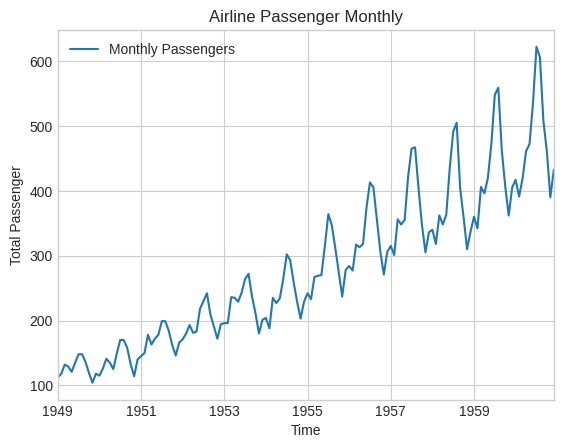

In [8]:
title = "Airline Passenger Monthly"

xlabel = "Time"

ylabel = "Total Passenger"

airline.plot.line(title=title, xlabel=xlabel, ylabel=ylabel);

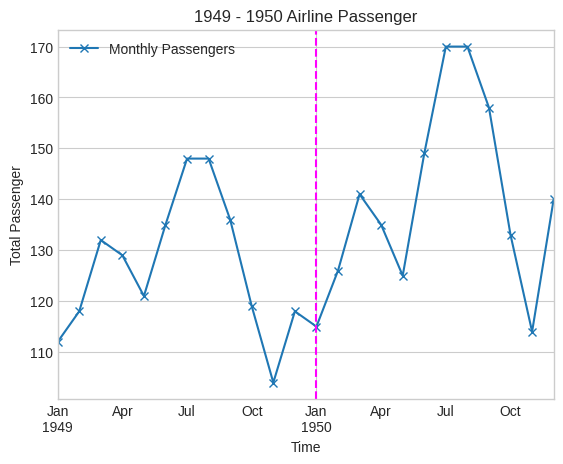

In [9]:
title = "1949 - 1950 Airline Passenger"

xlabel = "Time"

ylabel = "Total Passenger"

series = airline["1949-01-01":"1950-12-31"]

axes = series.plot.line(title=title, xlabel=xlabel, ylabel=ylabel, marker="x")

axes.axvline("1950-01-01", color="magenta", linestyle="--");

On 1949 and 1950, There are *Seasonality* on Yearly Basis

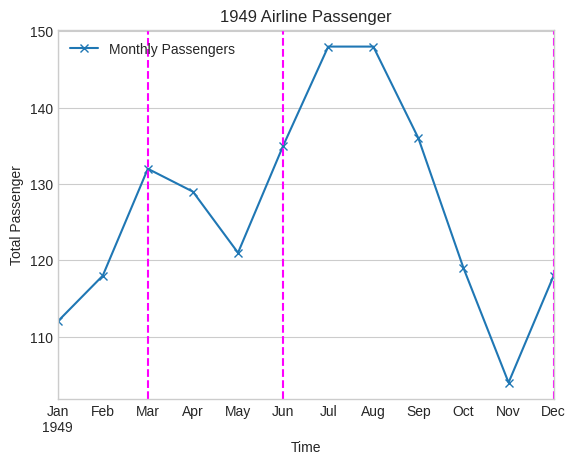

In [10]:
title = "1949 Airline Passenger"

xlabel = "Time"

ylabel = "Total Passenger"

series = airline["1949-01-01":"1949-12-01"]

axes = series.plot.line(title=title, xlabel=xlabel, ylabel=ylabel, marker="x")

for lab in ["1949-03", "1949-06", "1949-12"]:

  axes.axvline(lab, color="magenta", linestyle="--")

Our Total Monthly Passengers *Increased on March, June, and December* and *Decreased on May and September*

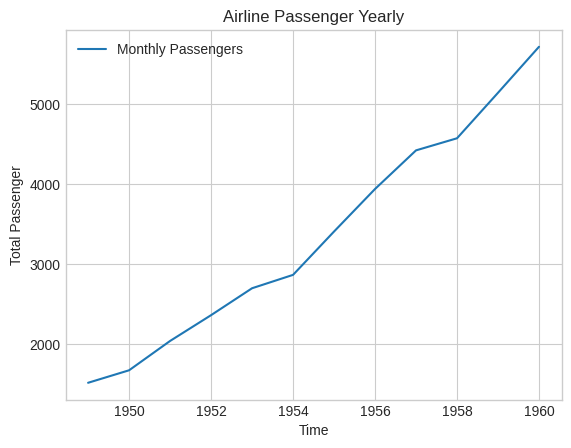

In [11]:
total = airline.groupby(airline.index.year).sum()

title = "Airline Passenger Yearly"

total.plot.line(title=title, xlabel=xlabel, ylabel=ylabel);

🚀 Ch.01 Plot Result

Our Airline Table is in January 1949 to December 1960

Over the Years, Our Monthly Total Passengers Trend is *Increasing* and also Having Consistent *Seasonality*

Main Reason on Our Monthly Total Passengers *Seasonality* is *Holiday*

On June to August, *in the Northern Hemisphere is Summer Holiday*. On December, is *Christmas and New Year Eve*

### Ch.02 : Airline Test

In [12]:
from statsmodels.tools.sm_exceptions import ValueWarning

from statsmodels.tsa.seasonal import seasonal_decompose

warnings.simplefilter('ignore', ValueWarning)

airline_report = seasonal_decompose(airline)

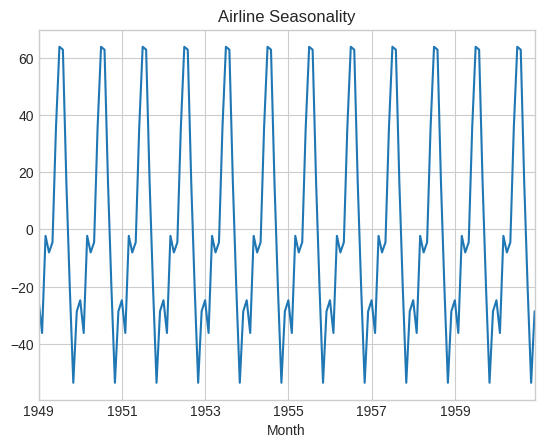

In [13]:
title  = "Airline Seasonality"

airline_report.seasonal.plot(title=title);

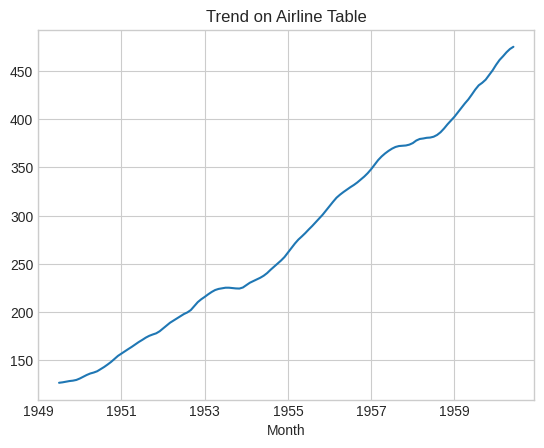

In [14]:
title  = "Trend on Airline Table"

airline_report.trend.plot(title=title);

In [15]:
# Original Airline ADF Test

from statsmodels.tsa.stattools import adfuller

test_result, p_value, use_lag, obser, crival, criterion = adfuller(airline)

alpha = 0.05

is_stationar = test_result < alpha

is_stationar, test_result

(False, 0.8153688792060498)

In [16]:
# First Order ADF Test

sample_satu = airline.diff().dropna()

test_result, p_value, use_lag, obser, crival, criterion = adfuller(sample_satu)

is_stationar = test_result < alpha

is_stationar, test_result

(True, -2.8292668241700047)

Initially, Our Airline Table *isn't Stationary*. Our Airline *is Stationary at First Order Diff*

We'll Use Sample Satu Table to ACF & PACF Plot

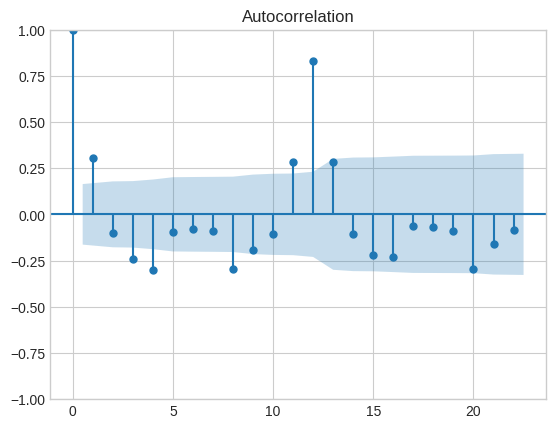

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sample_satu);

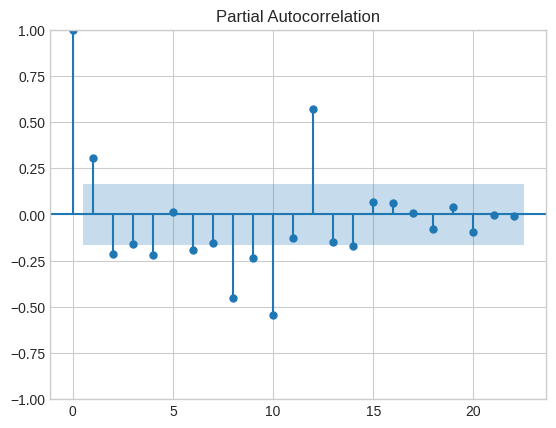

In [18]:
plot_pacf(sample_satu);

🚀 Ch.02 Plot Result

Due to *First Order Diff*, Our *d* Will be 1. Our *p* Will be 1 or 2. Our *q* Will be 1

### Ch.03 : Airline Model

Our Airline Model will Consist of *Arima* and *Seasonal Arima*

#### Ch.03.1 : Arima

In [19]:
import os, urllib

if not os.path.exists("Relplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Air/refs/heads/main/Relplot.py"

  urllib.request.urlretrieve(giturl, "Relplot.py")

In [20]:
train_split = int(0.95 * total_airline)

train = airline.iloc[:train_split]

test = airline.iloc[train_split:]

len(train), len(test)

(136, 8)

In [21]:
import numpy as np

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

orders = [(1, 1, 1), (2, 1, 1)]

errors = []; error_list = []

for order in orders:

  arima_model = ARIMA(train, order=order).fit()

  logits = arima_model.forecast(len(test))

  error = np.sqrt(mean_squared_error(test, logits))

  errors.append(error); error_list.append(arima_model.aic)

np.argmin(error_list), np.argmin(errors)

(1, 0)

In [22]:
error_list

[1293.955673573179, 1284.5433596019288]

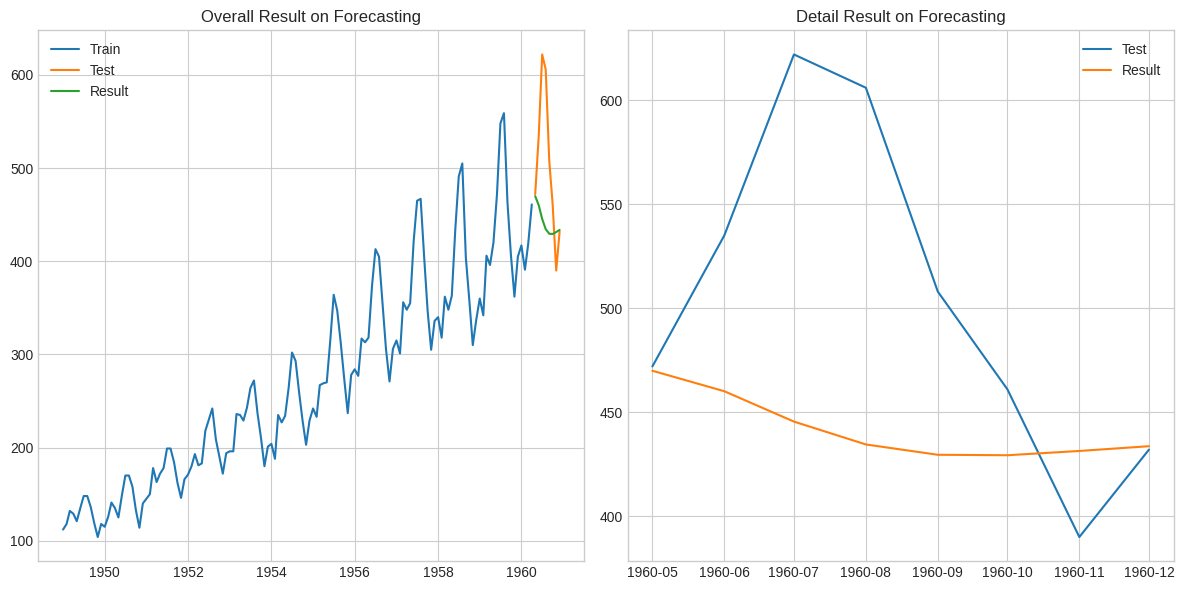

In [23]:
from Relplot import Relplot

order = orders[np.argmin(error_list)]

arima_model = ARIMA(train, order=order).fit()

logits = arima_model.forecast(len(test))

result = Relplot(train, test, logits)

result.Relplot

🚀 Arima Result

*Our Arima Model is Performing !*

But, Our Model is Fail to Get the *Seasonal* Aspect of Our Monthly Total Passengers

We'll Use *Seasonal Arima* on Chapter 3 Part 2

#### Ch.03.2 : Seasonal Arima

Due to Highest Value in ACF Plot, Our *S* Component on Seasonal Arima Will be 12

In [24]:
orders = [(1, 1, 1), (2, 1, 1)]

error_rate = []; model_aic = []

for order in orders:

  seasonal_arima_model = ARIMA(train, order=order, seasonal_order=(1, 1, 0, 12)).fit()

  logits = seasonal_arima_model.forecast(len(test))

  error = np.sqrt(mean_squared_error(test, logits))

  error_rate.append(error)

  model_aic.append(seasonal_arima_model.aic)

error_rate

[15.42558778194235, 13.391104049149394]

In [25]:
model_aic

[956.4344664103467, 953.4313979239381]

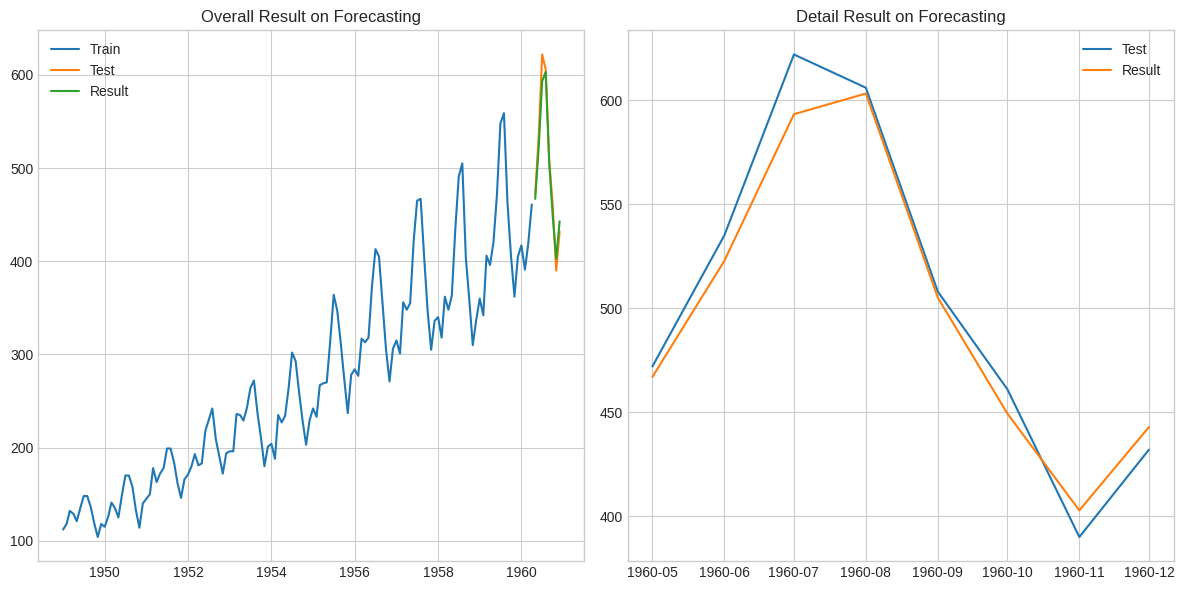

In [26]:
order = orders[np.argmin(model_aic)]

seasonal_arima_model = ARIMA(train, order=order, seasonal_order=(1, 1, 0, 12)).fit()

logits = seasonal_arima_model.forecast(len(test))

result = Relplot(train, test, logits)

result.Relplot

🚀 Seasonal Arima Result

*Our Seasonal Arima Model is Magnifico !*

Our Final Model is *Seasonal Arima with Order (2, 1, 1) and Seasonal Order (1, 1, 0, 12)*

We'll Forecast Our Total Monthly Airline Passengers on 1961

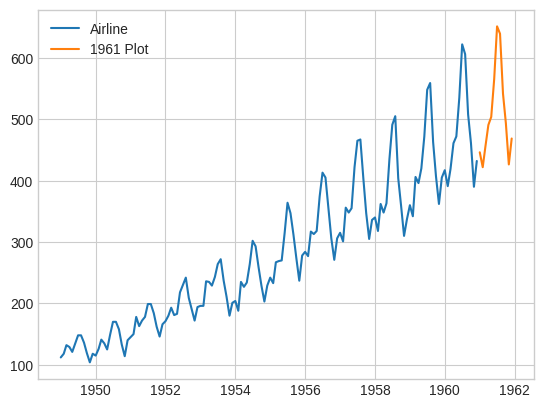

In [27]:
overall_model = ARIMA(airline, order=(2, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()

logits = overall_model.forecast(12)

plt.plot(airline, label="Airline")

plt.plot(logits, label="1961 Plot")

plt.legend();

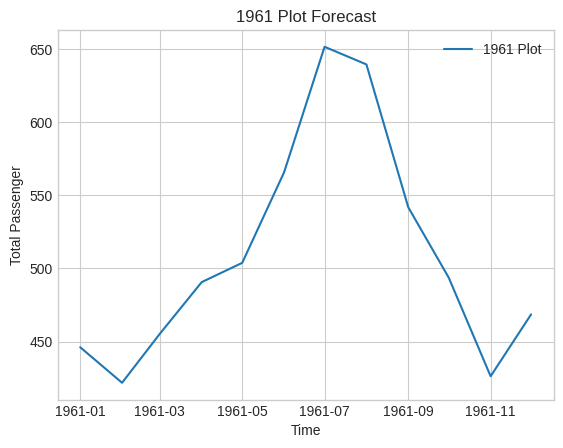

In [28]:
plt.plot(logits, label="1961 Plot")

plt.title("1961 Plot Forecast")

plt.xlabel("Time")

plt.ylabel("Total Passenger")

plt.legend();

Our Model is Forecasting that the Peak of Our Total Airline Passengers is in July, During the Summer Holiday

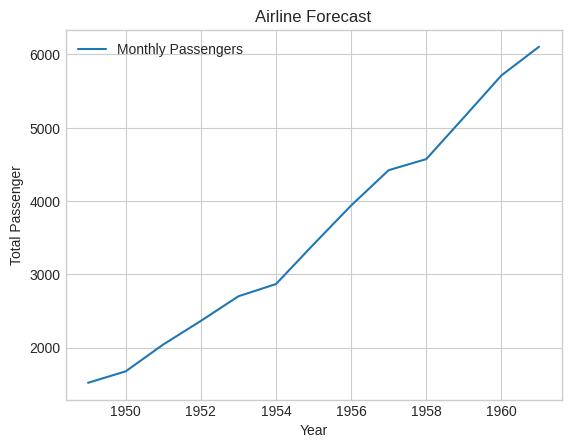

In [29]:
logits_indices = pandas.date_range(start='1961-01-01', end='1961-12-01', freq='MS')

logits_table = pandas.Series(logits, index=logits_indices, name='Monthly Passengers')

airline_logits = pandas.concat([airline, logits_table])

yearly = airline_logits.groupby(airline_logits.index.year).sum()

yearplot = yearly.plot.line(title="Airline Forecast", xlabel="Year", ylabel="Total Passenger");

Overall, *Our Total Yearly Passengers is Increasing*